In [1]:
import requests
import json
import pandas as pd
import calendar
import numpy as np
import io
import tarfile
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression

### Final Deliverables (20%)
- Final Report + Recorded Presentation Due: December 9
  - Includes Statement of Contributions (Each Student)

The Final Group Project will be conducted in groups of two to four students and must demonstrate each group member's mastery and understanding of the course material. This understanding will be demonstrated through each phase of the project. In summary, each project group will:

* collect data via an API or web scraping (Phase I)
* develop at least two key questions of interest for which the collected data may help answer (Phase I)
* clean and preprocess the data in preparation for addressing these questions (Phase II)
* include at least two visualizations of the data and numerical analysis that help in either understanding or solving the questions of interest (Phase II)
* apply two machine learning or modeling methods as a form of analysis to help in answering the questions of interest (Phase II/III)
  * **ONE OF WHICH MUST** be coded manually (using maths/NumPy) and second which may (if you choose) use a pre-built python module like `scikit-learn`.

In [2]:
owner = "AtharvaN88"
repo = "GSE-by-year"
api_url = f"https://api.github.com/repos/{owner}/{repo}/contents"

response = requests.get(api_url)
if response.status_code != 200:
    raise Exception(f"Failed to fetch repo contents: {response.status_code}, {response.text}")

repo_contents = response.json()

tar_files = [item for item in repo_contents if item['name'].endswith('.tar.gz')]
all_dataframes = []

for tar_file in tar_files:
    tar_url = tar_file['download_url']
    tar_response = requests.get(tar_url)
    
    if tar_response.status_code != 200:
        raise Exception(f"Failed to download {tar_file['name']}: {tar_response.status_code}, {tar_response.text}")
    
    with tarfile.open(fileobj=io.BytesIO(tar_response.content), mode="r:gz") as tar:
        for member in tar.getmembers():
            if member.isfile() and member.name.endswith('.csv'):
                csv_file = tar.extractfile(member)
                if csv_file:
                    df = pd.read_csv(csv_file)
                    all_dataframes.append(df)

main_df = pd.concat(all_dataframes, ignore_index=True)

main_df


,service_date,time_period,stop_id,station_name,route_or_line,gated_entries
0,2021-12-31,(00:00:00),place-alfcl,Alewife,Red Line,2.0
1,2021-12-31,(00:00:00),place-chmnl,Charles/MGH,Red Line,1.0
2,2021-12-31,(00:00:00),place-coecl,Copley,Green Line,12.0
3,2021-12-31,(00:00:00),place-harsq,Harvard,Red Line,1.0
4,2021-12-31,(00:00:00),place-sstat,South Station,Red Line,0.7
...,...,...,...,...,...,...
4169809,2018-01-01,(23:30:00),place-welln,Wellington,Orange Line,6.0
4169810,2018-01-01,(23:30:00),place-wimnl,Wood Island,Blue Line,5.0
4169811,2018-01-01,(23:30:00),place-wondl,Wonderland,Blue Line,9.0
4169812,2018-01-01,(23:30:00),place-wtcst,World Trade Center,Silver Line,4.0


Train MSE: 21699.7442
Test MSE: 21938.4648


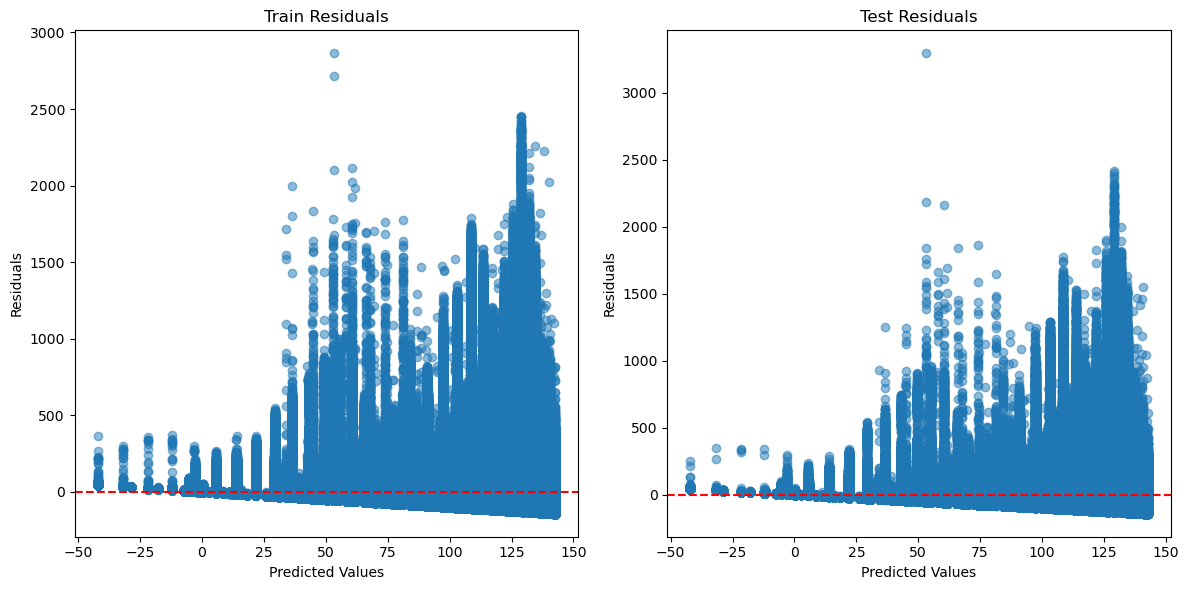

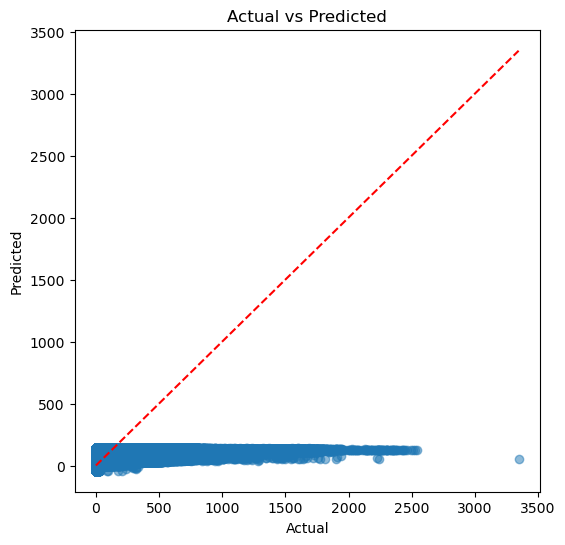

In [4]:
label_encoders = {}
for col in ['time_period', 'route_or_line']:
    le = LabelEncoder()
    main_df[col] = le.fit_transform(main_df[col].astype(str))
    label_encoders[col] = le

X = main_df[['time_period', 'route_or_line']]
y = main_df['gated_entries']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, train_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Train Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, test_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Test Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
